In [64]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
from itertools import chain
from random import sample 
from skimage import io
from PIL import Image
import pydicom

Findings

In [65]:
# Load the NIH data
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
109720,00029848_000.png,No Finding,0,29848,43,F,PA,2021,2021,0.194311,0.194311,NaN
87286,00021552_021.png,Effusion,21,21552,50,M,PA,2990,2991,0.143000,0.143000,NaN
4633,00001249_002.png,Edema,2,1249,40,M,AP,2500,2048,0.168000,0.168000,NaN


# Demographic data

Analyzing the age,gender and patient postition

(array([ 1803.,  6009., 13441., 16702., 22101., 27401., 17901.,  5865.,
          846.,    35.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

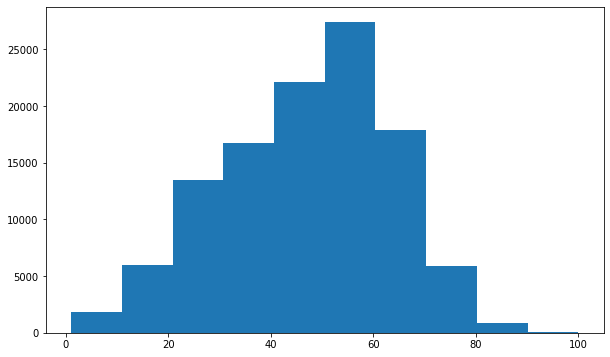

In [66]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], range=(1,100))

(array([63340.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 48780.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

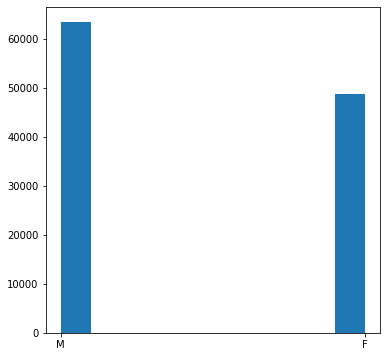

In [67]:
plt.figure(figsize=(6,6))
plt.hist(all_xray_df['Patient Gender'])

(array([67310.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 44810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

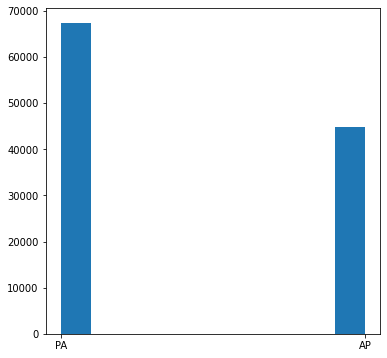

In [68]:

plt.figure(figsize=(6,6))
plt.hist(all_xray_df['View Position'])

In [69]:
# Demographic data 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
37472,00009877_006.png,No Finding,6,9877,33,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
62826,00015530_154.png,No Finding,154,15530,15,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
90244,00022431_001.png,No Finding,1,22431,61,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [70]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Patients with Disease')]

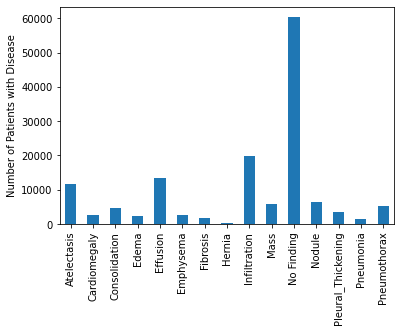

In [71]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Patients with Disease')

Above, I see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

However,since we are dealing with pneumonia, I'm going to now look at how frequently it appears with all of the other diseases:


<AxesSubplot:>

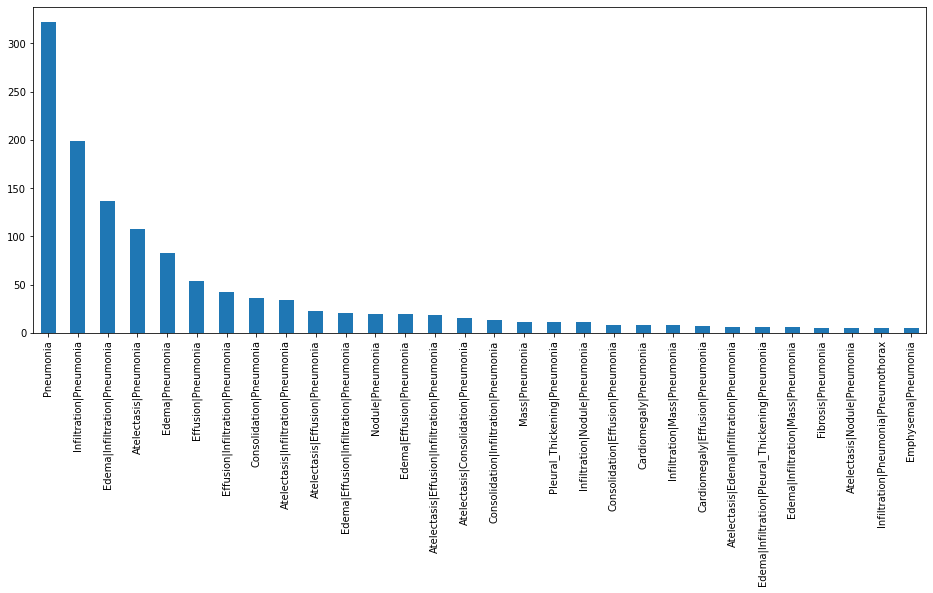

In [72]:
# Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [73]:
v = all_xray_df['Pneumonia'].value_counts()
print('There are: {} Pneumonia cases and: {} Non Pneumonia cases'.format(v[1],v[0]))

There are: 1431 Pneumonia cases and: 110689 Non Pneumonia cases


It looks like Pneumonia actually occurs alone for the most part, and that its most-common comorbidities are Infiltration, Edema and Atelectasis.




How does Pneumonia Corelate with age, gender and the position taken?

(array([ 41.,  95., 200., 247., 250., 299., 228.,  60.,  10.,   0.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

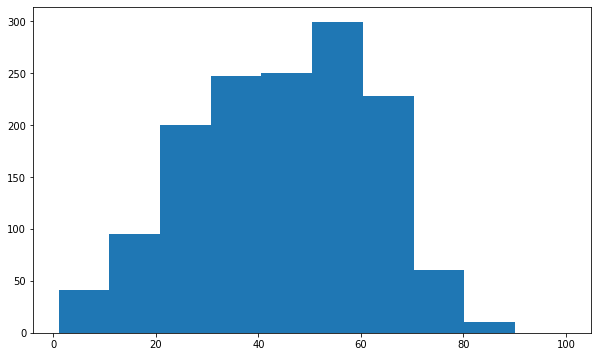

In [74]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], range =(1,100))

(array([838.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

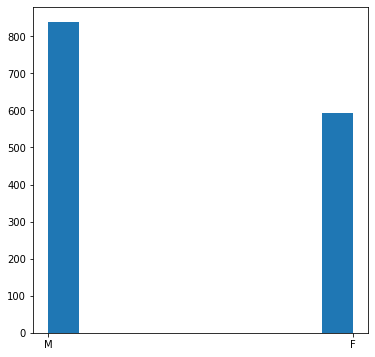

In [75]:
plt.figure(figsize=(6,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'])

(array([801.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

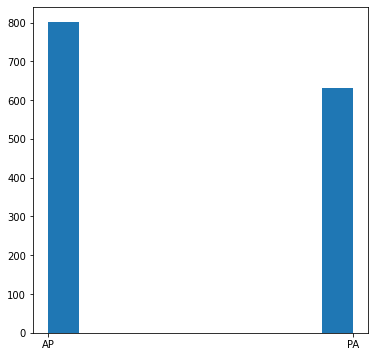

In [76]:
plt.figure(figsize=(6,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['View Position'])

In [77]:
# Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4463,00022234_000.png,No Finding,0,22234,039Y,M,PA,2982,2991,0.143,0.143,data\images\images\00022234_000.png
5033,00026733_000.png,No Finding,0,26733,056Y,M,PA,3056,2544,0.139,0.139,data\images\images\00026733_000.png
1333,00006973_002.png,Atelectasis|Effusion,2,6973,062Y,M,AP,2500,2048,0.171,0.171,data\images\images\00006973_002.png


In [78]:
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3354,00016550_019.png,Nodule,19,16550,019Y,M,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2551,00012834_105.png,Pleural_Thickening,105,12834,033Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4018,00019790_000.png,No Finding,0,19790,050Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


For the sample dataset, let's look at the most common comorbities with pneumonia

<AxesSubplot:>

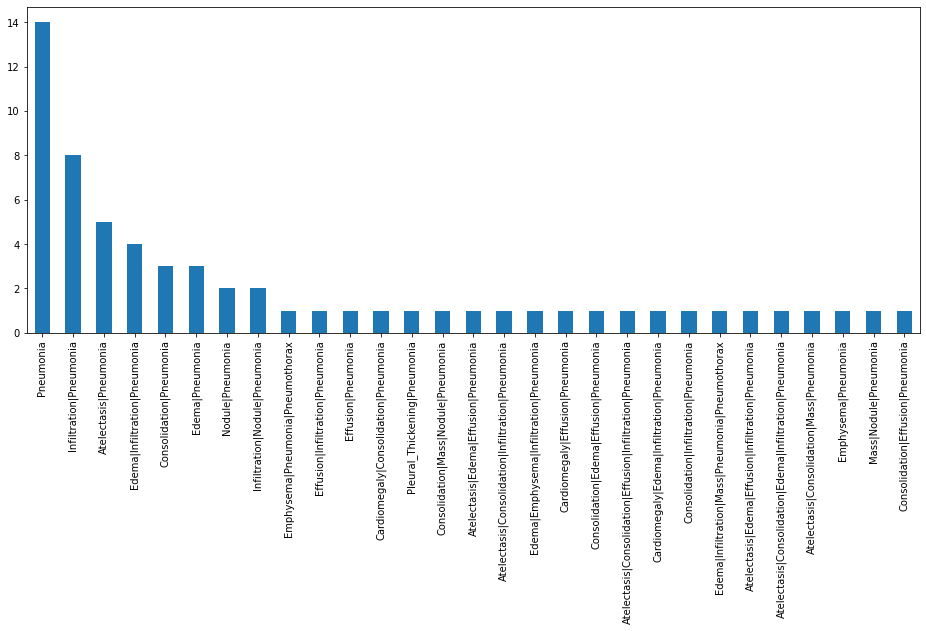

In [79]:
plt.figure(figsize=(16,6))
sample_df[sample_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

We see that pneumonia appears mostly with Infiltration,Atelectasis,Edema and Consolidation.
Looking at the highest comorbid diseases

In [80]:
coom = sample_df[sample_df.Pneumonia==1][sample_df.Edema==1][sample_df.Infiltration==1][sample_df.Atelectasis==1][sample_df.Consolidation==1]
coom

c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1871,00009863_007.png,Atelectasis|Consolidation|Edema|Infiltration|P...,7,9863,040Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Atelectasis|Consolidation|Edema|Infiltration|Pneumonia


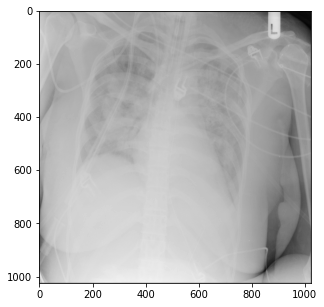

In [81]:
img = image.imread(coom.iloc[0].path)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap ='gray')
print(coom.iloc[0]['Finding Labels'])

(array([1.0000e+00, 1.0000e+01, 2.0000e+01, 5.1000e+01, 3.5000e+01,
        8.2000e+01, 1.3200e+02, 7.1000e+01, 1.3200e+02, 3.6900e+02,
        5.6300e+02, 5.4800e+02, 0.0000e+00, 4.4500e+02, 3.0000e+02,
        1.9400e+02, 8.3000e+01, 3.4000e+01, 2.5000e+01, 2.9000e+01,
        1.9000e+01, 2.9000e+01, 3.4000e+01, 3.4000e+01, 0.0000e+00,
        4.5000e+01, 2.6000e+01, 3.9000e+01, 4.5000e+01, 6.9000e+01,
        8.7000e+01, 8.2000e+01, 8.2000e+01, 9.0000e+01, 9.3000e+01,
        8.6000e+01, 0.0000e+00, 9.4000e+01, 1.0400e+02, 8.9000e+01,
        1.0900e+02, 1.1900e+02, 1.3000e+02, 1.4000e+02, 1.2300e+02,
        1.4200e+02, 1.5100e+02, 1.5500e+02, 0.0000e+00, 1.5800e+02,
        1.4400e+02, 1.7200e+02, 1.9100e+02, 2.1400e+02, 2.4100e+02,
        2.4900e+02, 2.3400e+02, 2.6300e+02, 2.6700e+02, 3.0000e+02,
        0.0000e+00, 2.5500e+02, 2.2500e+02, 2.2300e+02, 2.6200e+02,
        3.1400e+02, 4.0200e+02, 4.4400e+02, 4.8100e+02, 4.9200e+02,
        5.1000e+02, 4.7700e+02, 5.0900e+02, 0.00

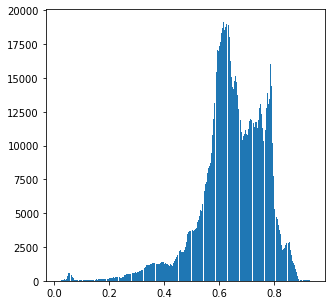

In [82]:
plt.figure(figsize=(5,5))
plt.hist(img.ravel(), bins = 256)

In [83]:
coom = sample_df[sample_df.Pneumonia==1][sample_df.Edema==1][sample_df.Infiltration==1][sample_df.Atelectasis==1][sample_df.Consolidation==0]
coom

c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1889,00009925_012.png,Atelectasis|Edema|Effusion|Infiltration|Pneumonia,12,9925,056Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Atelectasis|Edema|Effusion|Infiltration|Pneumonia


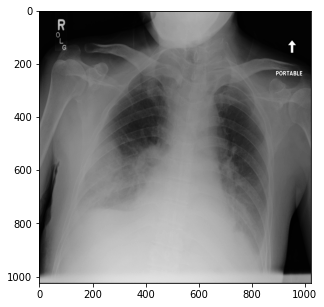

In [84]:
img = image.imread(coom.iloc[0].path)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap ='gray')
print(coom.iloc[0]['Finding Labels'])

(array([6.9100e+02, 1.5150e+03, 2.5700e+04, 5.6433e+04, 4.8280e+03,
        2.1570e+03, 2.0330e+03, 2.2130e+03, 2.6400e+03, 2.4180e+03,
        2.3250e+03, 2.3140e+03, 2.0930e+03, 1.8800e+03, 1.9900e+03,
        1.7910e+03, 1.8820e+03, 1.6830e+03, 1.4530e+03, 1.4990e+03,
        1.3690e+03, 1.3540e+03, 1.4330e+03, 1.4770e+03, 1.5370e+03,
        1.5170e+03, 1.5850e+03, 1.5590e+03, 1.6570e+03, 1.7840e+03,
        1.8600e+03, 2.1150e+03, 2.1490e+03, 2.2200e+03, 2.2680e+03,
        2.5580e+03, 2.6240e+03, 2.8700e+03, 2.8150e+03, 2.7960e+03,
        2.8820e+03, 3.0790e+03, 3.1710e+03, 3.1920e+03, 3.1940e+03,
        3.1880e+03, 3.0860e+03, 3.0940e+03, 3.0710e+03, 3.2340e+03,
        3.2300e+03, 3.1610e+03, 3.0360e+03, 3.1450e+03, 3.1330e+03,
        3.2830e+03, 3.1670e+03, 3.1220e+03, 3.1210e+03, 3.1130e+03,
        3.1010e+03, 3.0550e+03, 2.9040e+03, 2.9700e+03, 2.9800e+03,
        3.1830e+03, 3.1030e+03, 3.2880e+03, 3.2790e+03, 3.3260e+03,
        3.3100e+03, 3.3030e+03, 3.3830e+03, 3.49

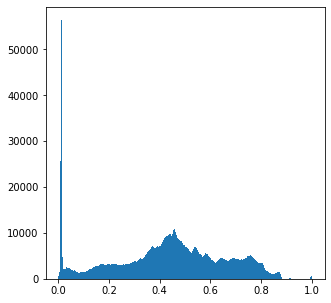

In [85]:
plt.figure(figsize=(5,5))
plt.hist(img.ravel(), bins = 256)

In [86]:
coom = sample_df[sample_df.Pneumonia==1][sample_df.Edema==1][sample_df.Infiltration==1][sample_df.Atelectasis==0][sample_df.Consolidation==0]
coom

c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1898,00009953_025.png,Edema|Infiltration|Mass|Pneumonia|Pneumothorax,25,9953,057Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2635,00013249_033.png,Cardiomegaly|Edema|Infiltration|Pneumonia,33,13249,015Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2860,00014149_029.png,Edema|Infiltration|Pneumonia,29,14149,059Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3540,00017504_058.png,Edema|Infiltration|Pneumonia,58,17504,012Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3541,00017504_062.png,Edema|Emphysema|Infiltration|Pneumonia,62,17504,012Y,F,AP,2500,2048,0.168,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3996,00019750_022.png,Edema|Infiltration|Pneumonia,22,19750,061Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4178,00020482_061.png,Edema|Infiltration|Pneumonia,61,20482,029Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Edema|Infiltration|Pneumonia


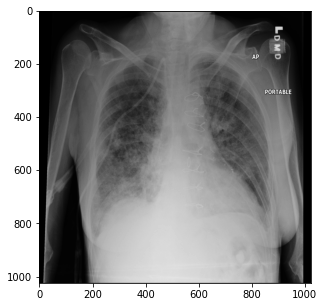

In [87]:
img = image.imread(coom.iloc[2].path)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap ='gray')
print(coom.iloc[2]['Finding Labels'])

(array([6.3124e+04, 1.8970e+03, 2.8082e+04, 1.9042e+04, 8.2990e+03,
        3.6850e+03, 3.8550e+03, 3.9980e+03, 3.8280e+03, 3.7260e+03,
        3.1520e+03, 2.9440e+03, 2.6760e+03, 2.7090e+03, 2.3490e+03,
        2.3020e+03, 2.3070e+03, 2.2340e+03, 2.3400e+03, 2.1350e+03,
        2.0930e+03, 1.9380e+03, 1.9470e+03, 2.0160e+03, 1.9610e+03,
        1.9860e+03, 1.8990e+03, 1.9730e+03, 2.0190e+03, 2.0000e+03,
        2.0080e+03, 2.0480e+03, 2.1130e+03, 2.1770e+03, 2.2080e+03,
        2.1770e+03, 2.2080e+03, 2.1880e+03, 2.2520e+03, 2.3670e+03,
        2.4530e+03, 2.5760e+03, 2.6220e+03, 2.7300e+03, 2.6610e+03,
        2.5470e+03, 2.4630e+03, 2.5430e+03, 2.7190e+03, 2.8160e+03,
        2.9220e+03, 3.0740e+03, 3.1010e+03, 3.2100e+03, 3.4510e+03,
        3.4370e+03, 3.7050e+03, 3.8590e+03, 4.0080e+03, 4.1690e+03,
        4.3230e+03, 4.3880e+03, 4.4710e+03, 4.6750e+03, 4.9910e+03,
        4.8980e+03, 5.1990e+03, 5.1610e+03, 5.2160e+03, 5.4210e+03,
        5.4830e+03, 5.3540e+03, 5.5970e+03, 5.59

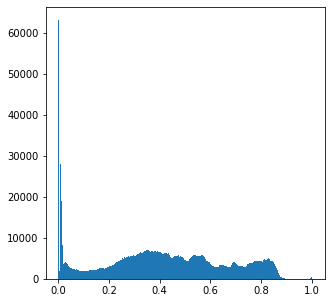

In [88]:
plt.figure(figsize=(5,5))
plt.hist(img.ravel(), bins = 256)

In [89]:
coom = sample_df[sample_df.Pneumonia==1][sample_df.Edema==1][sample_df.Infiltration==0][sample_df.Atelectasis==0][sample_df.Consolidation==0]
coom

c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2808,00014004_012.png,Edema|Pneumonia,12,14004,058Y,F,AP,2916,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2818,00014022_085.png,Edema|Pneumonia,85,14022,066Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4046,00019938_003.png,Edema|Pneumonia,3,19938,039Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Edema|Pneumonia


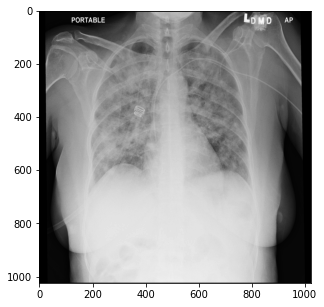

In [90]:
img = image.imread(coom.iloc[0].path)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap ='gray')
print(coom.iloc[0]['Finding Labels'])

(array([6.0578e+04, 2.7900e+02, 3.8000e+02, 2.3600e+03, 7.7060e+03,
        1.0655e+04, 1.5422e+04, 2.0436e+04, 7.6740e+03, 1.3020e+03,
        7.3600e+02, 5.7700e+02, 5.7200e+02, 6.8500e+02, 7.6800e+02,
        9.3700e+02, 1.1350e+03, 1.0700e+03, 1.1330e+03, 1.1560e+03,
        1.1500e+03, 1.1500e+03, 1.1370e+03, 1.1650e+03, 1.1860e+03,
        1.1690e+03, 1.0690e+03, 1.0530e+03, 1.3200e+03, 1.2020e+03,
        1.1180e+03, 1.1490e+03, 1.2350e+03, 1.2590e+03, 1.1830e+03,
        1.1680e+03, 1.1580e+03, 1.2640e+03, 1.2110e+03, 1.2460e+03,
        1.2470e+03, 1.2450e+03, 1.3400e+03, 1.4030e+03, 1.4490e+03,
        1.4130e+03, 1.4030e+03, 1.2730e+03, 1.3510e+03, 1.3510e+03,
        1.3890e+03, 1.3820e+03, 1.3700e+03, 1.3960e+03, 1.3840e+03,
        1.3810e+03, 1.3650e+03, 1.4320e+03, 1.4600e+03, 1.5340e+03,
        1.5390e+03, 1.4590e+03, 1.4530e+03, 1.5630e+03, 1.6630e+03,
        1.7600e+03, 1.7480e+03, 1.7710e+03, 1.7940e+03, 1.7040e+03,
        1.6980e+03, 1.6000e+03, 1.6520e+03, 1.57

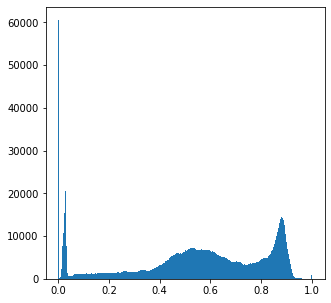

In [91]:
plt.figure(figsize=(5,5))
plt.hist(img.ravel(), bins = 256)

In [92]:
coom = sample_df[sample_df.Pneumonia==1][sample_df.Edema==0][sample_df.Infiltration==1][sample_df.Atelectasis==0][sample_df.Consolidation==0]
coom

c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2035,00010552_005.png,Infiltration|Pneumonia,5,10552,039Y,M,PA,2622,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2148,00011104_004.png,Infiltration|Nodule|Pneumonia,4,11104,060Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2183,00011251_010.png,Infiltration|Pneumonia,10,11251,076Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3057,00015069_000.png,Infiltration|Pneumonia,0,15069,025Y,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3403,00016786_001.png,Infiltration|Pneumonia,1,16786,023Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3404,00016786_005.png,Infiltration|Pneumonia,5,16786,023Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3894,00019176_089.png,Infiltration|Pneumonia,89,19176,066Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4176,00020482_025.png,Infiltration|Pneumonia,25,20482,029Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4618,00023089_004.png,Infiltration|Pneumonia,4,23089,059Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Infiltration|Pneumonia


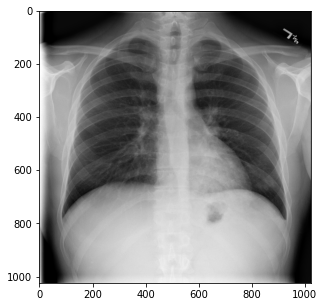

In [93]:
img = image.imread(coom.iloc[1].path)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap ='gray')
print(coom.iloc[1]['Finding Labels'])

(array([11463.,  1749.,  2030.,  2096.,  2631.,  3239.,  3975.,  6102.,
         6258.,  7495., 15448.,  1394.,  1030.,   976.,  1020.,   993.,
          932.,   899.,   901.,   939.,   919.,   984.,   919.,   906.,
         1011.,  1000.,  1078.,  1276.,  1375.,  1551.,  1608.,  1890.,
         2174.,  2422.,  2661.,  2898.,  3148.,  3365.,  3470.,  3811.,
         4030.,  4050.,  4093.,  4432.,  4562.,  4785.,  5061.,  5109.,
         5441.,  5436.,  5574.,  5617.,  5727.,  5690.,  5642.,  5653.,
         5566.,  5702.,  5528.,  5659.,  5518.,  5508.,  5588.,  5466.,
         5615.,  5689.,  5802.,  5921.,  5981.,  5800.,  5746.,  5619.,
         5427.,  5297.,  5229.,  5050.,  4901.,  4735.,  4733.,  4649.,
         4539.,  4282.,  4237.,  4132.,  4044.,  3799.,  3741.,  3546.,
         3639.,  3642.,  3563.,  3639.,  3646.,  3633.,  3642.,  3652.,
         3499.,  3718.,  3639.,  3743.,  3668.,  3728.,  3767.,  3695.,
         3737.,  3824.,  3780.,  3942.,  3935.,  3845.,  3910., 

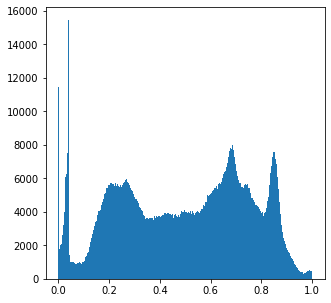

In [94]:
plt.figure(figsize=(5,5))
plt.hist(img.ravel(), bins = 256)

In [95]:
coom = sample_df[sample_df.Pneumonia==1][sample_df.Edema==0][sample_df.Infiltration==0][sample_df.Atelectasis==0][sample_df.Consolidation==0]
coom.sample(3)

c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
775,00004074_000.png,Mass|Nodule|Pneumonia,0,4074,047Y,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Pneumonia


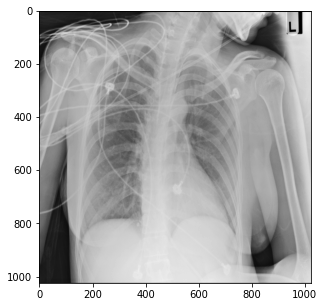

In [96]:
img = image.imread(coom.iloc[4].path)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap ='gray')
print(coom.iloc[4]['Finding Labels'])

(array([7.2000e+02, 1.5080e+03, 5.7400e+02, 6.9900e+02, 1.6400e+02,
        3.8000e+01, 3.8000e+01, 3.2000e+01, 3.6000e+01, 0.0000e+00,
        4.6000e+01, 1.0200e+02, 1.7900e+02, 3.2600e+02, 4.9300e+02,
        8.4700e+02, 1.2240e+03, 1.5200e+03, 0.0000e+00, 1.9780e+03,
        1.7340e+03, 1.7600e+03, 2.2180e+03, 2.8560e+03, 3.5350e+03,
        4.7210e+03, 4.0610e+03, 0.0000e+00, 3.9370e+03, 3.6530e+03,
        3.1180e+03, 2.9140e+03, 2.5800e+03, 2.4480e+03, 1.9960e+03,
        1.8610e+03, 0.0000e+00, 1.5330e+03, 1.2700e+03, 1.2220e+03,
        1.0400e+03, 8.3700e+02, 7.4200e+02, 7.0300e+02, 6.8000e+02,
        0.0000e+00, 6.8500e+02, 7.0200e+02, 7.0900e+02, 6.4600e+02,
        7.3900e+02, 7.3100e+02, 7.3900e+02, 7.4900e+02, 0.0000e+00,
        7.1000e+02, 8.4000e+02, 7.7100e+02, 8.4200e+02, 8.2900e+02,
        8.1300e+02, 8.7500e+02, 9.2200e+02, 0.0000e+00, 9.8700e+02,
        8.8200e+02, 8.5700e+02, 9.1400e+02, 1.0170e+03, 1.0210e+03,
        1.1570e+03, 1.0130e+03, 1.1350e+03, 0.00

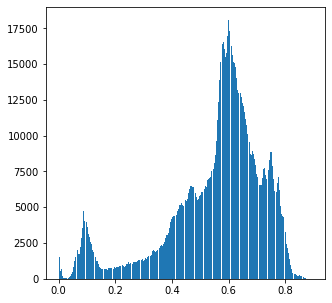

In [97]:
plt.figure(figsize=(5,5))
plt.hist(img.ravel(), bins = 256)

From the intensity profiles of the images above, we can see that the images different labels have different intensity profiles But all have some peaks at around 0.62 and 0.78 which we can observe in the last image with Pneumonia only. The peaks at 0 are mostly produced from the background.

# Dicoms

In [98]:
mydcm = glob("*.dcm")
dcm1 = pydicom.dcmread(mydcm[0])
dcm1


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patien

In [99]:
# Dicoms with Pneumonia
all_data = []

for i in mydcm: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns, dcm.pixel_array]
    all_data.append(fields)
        
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns','Pixel'])
mydata.sort_values(by=['Findings'])

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns,Pixel
1,1,58,M,DX,Cardiomegaly,1024,1024,"[[202, 199, 195, 193, 195, 194, 193, 192, 184,..."
2,61,77,M,DX,Effusion,1024,1024,"[[142, 142, 143, 141, 143, 140, 140, 136, 137,..."
0,2,81,M,DX,No Finding,1024,1024,"[[199, 175, 152, 133, 124, 118, 113, 111, 110,..."
3,2,81,M,DX,No Finding,1024,1024,"[[199, 175, 152, 133, 124, 118, 113, 111, 110,..."
4,2,81,M,CT,No Finding,1024,1024,"[[199, 175, 152, 133, 124, 118, 113, 111, 110,..."
5,2,81,M,DX,No Finding,1024,1024,"[[199, 175, 152, 133, 124, 118, 113, 111, 110,..."


From here, we can see that 4 on 6 images have no findings.

No Finding


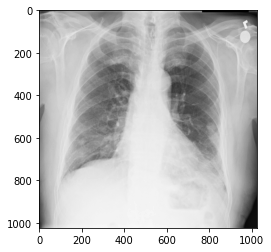

In [100]:
label=mydata.loc[0].Findings
plt.imshow(mydata.loc[0].Pixel,cmap='gray')
print(label)
    

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

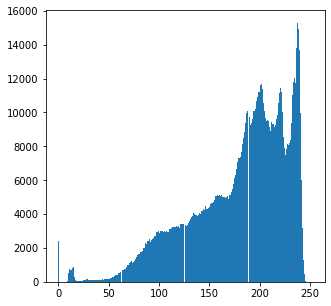

In [101]:
plt.figure(figsize=(5,5))
plt.hist(mydata.loc[0].Pixel.ravel(), bins = 256)

Cardiomegaly


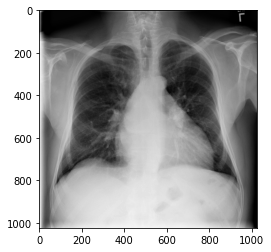

In [102]:
label=mydata.loc[1].Findings
plt.imshow(mydata.loc[1].Pixel,cmap='gray')
print(label)

(array([13386.,  2532.,  3043.,  4455.,  7220.,  7741.,  1954.,  1499.,
         1278.,  1154.,  1208.,  1226.,  1329.,  1421.,  1385.,  1449.,
         1521.,  1662.,  1678.,  1892.,  2060.,  2038.,  2205.,  2404.,
         2561.,  2628.,  2800.,  2834.,  3012.,  3106.,  3086.,  3300.,
         3427.,  3422.,  3636.,  3759.,  3973.,  3954.,  4013.,  4040.,
         4284.,  4169.,  4200.,  4232.,  4474.,  4588.,  4616.,  4695.,
         4691.,  4671.,  4842.,  4959.,  4900.,  5059.,  5207.,  5314.,
         5165.,  5089.,  5027.,  5015.,  5077.,  4751.,  4851.,  4585.,
         4714.,  4449.,  4438.,  4351.,  4327.,  4348.,  4285.,  4302.,
         4170.,  4235.,  4150.,  4249.,  4405.,  4410.,  4567.,  4570.,
         4531.,  4431.,  4186.,  3957.,  3985.,  3871.,  3711.,  3778.,
         3607.,  3584.,  3420.,  3416.,  3370.,  3459.,  3426.,  3422.,
         3441.,  3493.,  3457.,  3277.,  3184.,  3147.,  3180.,  3165.,
         3112.,  3213.,  3232.,  3260.,  3445.,  3550.,  3683., 

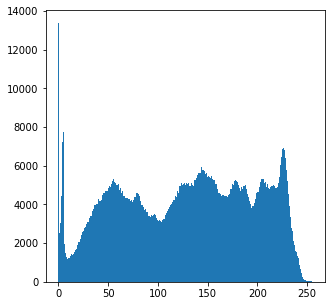

In [103]:
plt.figure(figsize=(5,5))
plt.hist(mydata.loc[1].Pixel.ravel(), bins = 256)

Effusion


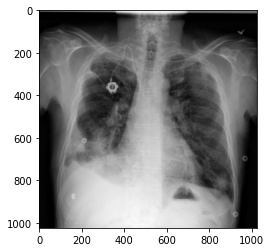

In [104]:
label=mydata.loc[2].Findings
plt.imshow(mydata.loc[2].Pixel,cmap='gray')
print(label)

(array([3.5061e+04, 8.4770e+03, 1.1659e+04, 1.5547e+04, 2.6001e+04,
        1.2153e+04, 2.3590e+03, 2.1880e+03, 2.2290e+03, 2.0000e+03,
        1.8530e+03, 1.7710e+03, 1.7830e+03, 1.8510e+03, 1.9450e+03,
        1.8240e+03, 1.8270e+03, 1.8310e+03, 1.8620e+03, 1.8820e+03,
        2.1060e+03, 2.0850e+03, 2.1490e+03, 2.2610e+03, 2.3450e+03,
        0.0000e+00, 2.3700e+03, 2.4940e+03, 2.7080e+03, 2.7610e+03,
        2.9390e+03, 2.9560e+03, 2.9950e+03, 3.0180e+03, 3.0560e+03,
        3.2820e+03, 3.3430e+03, 3.4600e+03, 3.5090e+03, 3.7450e+03,
        3.7580e+03, 3.8000e+03, 4.0730e+03, 4.3480e+03, 4.4720e+03,
        4.4720e+03, 4.7580e+03, 4.7250e+03, 4.8530e+03, 4.8440e+03,
        4.8640e+03, 0.0000e+00, 4.8580e+03, 5.0440e+03, 5.1020e+03,
        5.2790e+03, 5.2400e+03, 5.4470e+03, 5.5970e+03, 5.4190e+03,
        5.4440e+03, 5.3410e+03, 5.4730e+03, 5.4880e+03, 5.6010e+03,
        5.7700e+03, 5.7040e+03, 5.7260e+03, 5.8040e+03, 5.8610e+03,
        6.0650e+03, 5.9290e+03, 5.8920e+03, 5.86

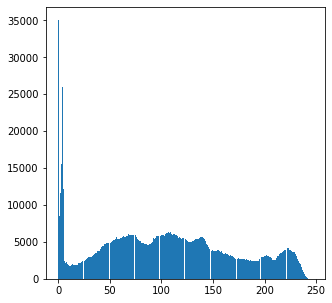

In [105]:
plt.figure(figsize=(5,5))
plt.hist(mydata.loc[2].Pixel.ravel(), bins = 256)

No Finding


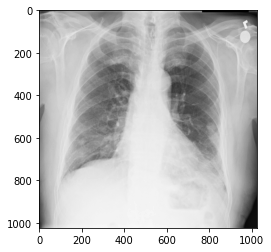

In [106]:
label=mydata.loc[3].Findings
plt.imshow(mydata.loc[3].Pixel,cmap='gray')
print(label)

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

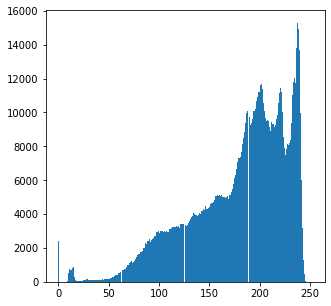

In [107]:
plt.figure(figsize=(5,5))
plt.hist(mydata.loc[3].Pixel.ravel(), bins = 256)

No Finding


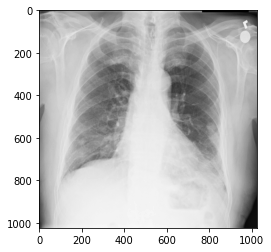

In [108]:
label=mydata.loc[4].Findings
plt.imshow(mydata.loc[4].Pixel,cmap='gray')
print(label)

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

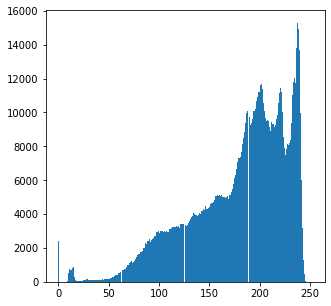

In [109]:
plt.figure(figsize=(5,5))
plt.hist(mydata.loc[4].Pixel.ravel(), bins = 256)

No Finding


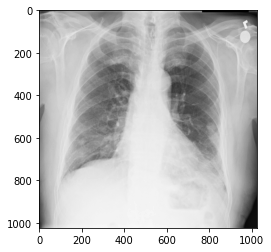

In [110]:
label=mydata.loc[5].Findings
plt.imshow(mydata.loc[5].Pixel,cmap='gray')
print(label)

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

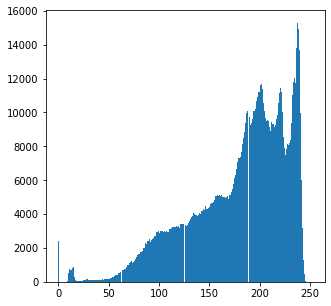

In [63]:
plt.figure(figsize=(5,5))
plt.hist(mydata.loc[5].Pixel.ravel(), bins = 256)

From the intensity profiles of the images above, we can see that the images with the same label have somewhat the same intensity profiles.We can see that the images with the label NO FINDING all have a peak intensity at aroud `230 to 245` aside from `0` which is mostly produced from the background.